In [121]:
import pickle, os, sys, math
import numpy as np
import pandas as pd
import seaborn as sns
from numpy import random
import matplotlib.pyplot as plt

PROJECT_DIR = os.path.dirname(os.path.dirname(os.getcwd()))
sys.path.insert(1, PROJECT_DIR)

from samples.data_sim import remove_feature
from city_pv_uni_modal import CityPV_UniModal
from city_pv_multi_modal import CityPV_MultiModal
from feature_selection import tune_pacf, rfecv_selection
from utils_pv import get_available_modules, get_available_inverters, visualize_pv, visualize_env, adj_r2_scorer
from samples.data_sim import PVDataset

random_seed = 3
random.seed(random_seed)
np.random.seed(random_seed)
random_state = np.random.RandomState(random_seed)


## Loading the Data
Data generated in samples/PV_generation/2_feature_engineering.ipynb
 
### Train-Test Split
* only in June and July
* different training scenarios using 2 weeks, 1 year, 5 years, and 14 years of data between 2005-2018 for training
* always test on June and July of 2019 (non-overlapping with the training set)

In [122]:
# Name of the experiment
exp_name = 'PV_UniModal'

def open_experiment(exp_name):
    filename_env = os.getcwd() + '/../../saved_results/' + exp_name + '_env' 
    file = open(filename_env + '_feat_eng', 'rb')
    env_dict = pickle.load(file)
    file.close()
    return env_dict

env_dict = open_experiment(exp_name)


#msg = '[INFO] loaded data for {:2.0f} clients'.format(env_dict['num_clients']) no need to store msg in a variable
#print('\n'+env_dict['info'])
print(f"[INFO] loaded data for {env_dict['num_clients']:2.0f} clients' \n\n{env_dict['info']}")

for scenario_name in env_dict['train_scenarios'].keys():
    print(scenario_name + ' has {:3.0f} train and {:3.0f} validation samples'.format(
                    env_dict['train_scenarios'][scenario_name]['clients_data'][0][0].shape[0],
                    env_dict['train_scenarios'][scenario_name]['clients_data'][0][2].shape[0]))
print('number of features = {:2.0f}'.format(
                    env_dict['train_scenarios'][scenario_name]['clients_data'][0][0].shape[1]))


[INFO] loaded data for 24 clients' 

24 households at Lausanne - tilt_std: 5.0, az_std: 15.0, weather_dev: 0.1, irrad_std: 0.2, altitude_dev: 0.1, shadow_peak_red: 0.8, different module_name, different inverter_name, 
sml has 150 train and 610 validation samples
1y has 610 train and 610 validation samples
5y has 3050 train and 610 validation samples
14y has 8540 train and 610 validation samples
number of features = 22


In [164]:
#Understanding the data and the features
print(f"The data has the following fields {env_dict.keys()}")
print(f"city name {env_dict['city_names']}")
print(f"number of clients {env_dict['num_clients']}, or number of buildings ")
print(f"number of modes {env_dict['num_modes']}")
print(f"number of lags {env_dict['lags']}")
print(f"Months of the sample {env_dict['months']}")
print(f"hours of the sample {env_dict['hours']}")


The data has the following fields dict_keys(['city_names', 'num_clients', 'num_modes', 'tilt_std', 'az_std', 'weather_dev', 'irrad_std', 'altitude_dev', 'shadow_peak_red', 'module_name', 'inverter_name', 'lags', 'months', 'hours', 'use_station_irrad_direct', 'use_station_irrad_diffuse', 'delay_irrad', 'remove_constant_cols', 'train_scenarios', 'tilt_mean', 'az_mean', 'num_clients_per_mode', 'info', 'clients_config', 'feature_names'])
city name ['Lausanne']
number of clients 24, or number of buildings 
number of modes 1
number of lags [1, 2, 3, 4, 18, 20, 21, 22, 43, 44, 69, 70, 72, 74, 121, 145, 169, 190]
Months of the sample [6, 7]
hours of the sample [ 8  9 10 11 12 13 14 15 16 17]


In [165]:
"""
env_dict['train_scenarios']['14y']['clients_data'][n][i]
n - nth client , i = [0,1,2,3]= X_train, y_train, X_val, y_val
    per client
sml has 150 train and 610 validation samples
1y has 610 train and 610 validation samples
5y has 3050 train and 610 validation samples
14y has 8540 train and 610 validation samples
"""
print(len(env_dict['train_scenarios']['14y']['time_series']))
# Per client I will stract their data and turn them into data frames to handle 
client_frames = [pd.DataFrame(n) for n in env_dict['train_scenarios']['14y']['time_series']]
# Then I transform each client into a number (this can be merged later), it could even be changet to an az angle 
keyes = [k for k in range(len(client_frames))]
df_complete = pd.concat(client_frames, keys = keyes )
df_complete.head()

24


time  H_sun       T2m     WS10m  hour_day  month  year  \
0 190 2005-01-08 23:10:00    0.0 -0.522446  2.168426        23      1  2005   
  191 2005-01-09 00:10:00    0.0 -2.314777  0.581209         0      1  2005   
  192 2005-01-09 01:10:00    0.0  6.125001  0.613983         1      1  2005   
  193 2005-01-09 02:10:00    0.0  4.135471  1.890860         2      1  2005   
  194 2005-01-09 03:10:00    0.0  0.177227  1.080805         3      1  2005   

       hourofd_x  hourofd_y  dayofy_x  ...  lag 69  lag 70  lag 72  lag 74  \
0 190  -0.258819   0.965926  0.137279  ...     0.0     0.0     0.0     0.0   
  191   0.000000   1.000000  0.154309  ...     0.0     0.0     0.0     0.0   
  192   0.258819   0.965926  0.154309  ...     0.0     0.0     0.0     0.0   
  193   0.500000   0.866025  0.154309  ...     0.0     0.0     0.0     0.0   
  194   0.707107   0.707107  0.154309  ...     0.0     0.0     0.0     0.0   

       lag 121  lag 145  lag 169  lag 190  is_train  is_valid  
0 190      0.0      0.0      0.0      0.0     False     False  
  191      0.0      0.0      0.0      0.0     False     False  
  192      0.0      0.0      0.0      0.0     False     False  
  193      0.0      0.0      0.0      0.0     False     False  
  194      0.0      0.0      0.0      0.0     False     False  

[5 rows x 34 columns]

In [166]:
# This step just assigns the data to each client, this can be grouped again if needed. 
df_complete['time'] = pd.to_datetime(df_complete['time'])
reset = df_complete.reset_index()
reset = reset.set_index(reset['time'])
reset = reset.drop(['level_1', 'time'],axis=1)
reset.rename(columns = {'level_0':'num_client'}, inplace = True)
reset.head()

num_client  H_sun       T2m     WS10m  hour_day  month  \
time                                                                          
2005-01-08 23:10:00           0    0.0 -0.522446  2.168426        23      1   
2005-01-09 00:10:00           0    0.0 -2.314777  0.581209         0      1   
2005-01-09 01:10:00           0    0.0  6.125001  0.613983         1      1   
2005-01-09 02:10:00           0    0.0  4.135471  1.890860         2      1   
2005-01-09 03:10:00           0    0.0  0.177227  1.080805         3      1   

                     year  hourofd_x  hourofd_y  dayofy_x  ...  lag 69  \
time                                                       ...           
2005-01-08 23:10:00  2005  -0.258819   0.965926  0.137279  ...     0.0   
2005-01-09 00:10:00  2005   0.000000   1.000000  0.154309  ...     0.0   
2005-01-09 01:10:00  2005   0.258819   0.965926  0.154309  ...     0.0   
2005-01-09 02:10:00  2005   0.500000   0.866025  0.154309  ...     0.0   
2005-01-09 03:10:00  2005   0.707107   0.707107  0.154309  ...     0.0   

                     lag 70  lag 72  lag 74  lag 121  lag 145  lag 169  \
time                                                                     
2005-01-08 23:10:00     0.0     0.0     0.0      0.0      0.0      0.0   
2005-01-09 00:10:00     0.0     0.0     0.0      0.0      0.0      0.0   
2005-01-09 01:10:00     0.0     0.0     0.0      0.0      0.0      0.0   
2005-01-09 02:10:00     0.0     0.0     0.0      0.0      0.0      0.0   
2005-01-09 03:10:00     0.0     0.0     0.0      0.0      0.0      0.0   

                     lag 190  is_train  is_valid  
time                                              
2005-01-08 23:10:00      0.0     False     False  
2005-01-09 00:10:00      0.0     False     False  
2005-01-09 01:10:00      0.0     False     False  
2005-01-09 02:10:00      0.0     False     False  
2005-01-09 03:10:00      0.0     False     False  

[5 rows x 34 columns]

In [192]:
# I will just separate the data to later use it. 
# Train set 
train_set = reset.loc[reset["is_train"]]
train_set = train_set.drop(["is_train","is_valid"], axis=1)
# Test set 
test_set = reset.loc[reset["is_train"]]
test_set = test_set.drop(["is_train","is_valid"], axis=1)

In [212]:
# # Data extraction for a single client
# # each client has 4 data frames X_train, y_train, X_val, y_val
ts_df = pd.DataFrame(env_dict['train_scenarios']['14y']['time_series'][0])
ts_df['time'] = pd.to_datetime(ts_df['time'])
ts_df.set_index('time', inplace=True)
ts_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 140065 entries, 2005-01-08 23:10:00 to 2020-12-31 23:10:00
Data columns (total 33 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   H_sun                       140065 non-null  float64
 1   T2m                         140065 non-null  float64
 2   WS10m                       140065 non-null  float64
 3   hour_day                    140065 non-null  int64  
 4   month                       140065 non-null  int64  
 5   year                        140065 non-null  int64  
 6   hourofd_x                   140065 non-null  float64
 7   hourofd_y                   140065 non-null  float64
 8   dayofy_x                    140065 non-null  float64
 9   dayofy_y                    140065 non-null  float64
 10  station_irrad_direct_prev   140065 non-null  float64
 11  station_irrad_diffuse_prev  140065 non-null  float64
 12  target                      140065 non

In [221]:
import seaborn as sns
# ts_df = train_set
# for client number 0, all data between the given months 
time = ts_df.where((ts_df['year'] >= 2012) & (ts_df['month'] <= 12) & (ts_df['month'] >= 1)& (ts_df['hour_day'] < 18) & (ts_df['hour_day'] > 7))
time = time.dropna()
time.head()

H_sun        T2m     WS10m  hour_day  month    year  \
time                                                                       
2012-01-01 08:10:00   6.33  12.686122  0.695132       8.0    1.0  2012.0   
2012-01-01 09:10:00  13.01  12.742292  0.709900       9.0    1.0  2012.0   
2012-01-01 10:10:00  17.79   3.752296  0.729000      10.0    1.0  2012.0   
2012-01-01 11:10:00  20.22   9.385786  1.172298      11.0    1.0  2012.0   
2012-01-01 12:10:00  20.05  10.071602  0.586134      12.0    1.0  2012.0   

                        hourofd_x  hourofd_y  dayofy_x  dayofy_y  ...  \
time                                                              ...   
2012-01-01 08:10:00  8.660254e-01  -0.500000  0.017213  0.999852  ...   
2012-01-01 09:10:00  7.071068e-01  -0.707107  0.017213  0.999852  ...   
2012-01-01 10:10:00  5.000000e-01  -0.866025  0.017213  0.999852  ...   
2012-01-01 11:10:00  2.588190e-01  -0.965926  0.017213  0.999852  ...   
2012-01-01 12:10:00  1.224647e-16  -1.000000  0.017213  0.999852  ...   

                        lag 69     lag 70     lag 72     lag 74    lag 121  \
time                                                                         
2012-01-01 08:10:00  19.822914  32.376350   7.138659   0.000000   0.000000   
2012-01-01 09:10:00  20.650338  19.822914   7.611039   0.000000   7.585002   
2012-01-01 10:10:00   7.941663  20.650338  32.376350   7.138659  20.197281   
2012-01-01 11:10:00   5.390432   7.941663  19.822914   7.611039  26.242171   
2012-01-01 12:10:00   4.151120   5.390432  20.650338  32.376350  26.129054   

                       lag 145    lag 169    lag 190  is_train  is_valid  
time                                                                      
2012-01-01 08:10:00   0.000000   0.000000  11.446329     False     False  
2012-01-01 09:10:00   7.522128   6.976145  21.883478     False     False  
2012-01-01 10:10:00  22.447277  21.700879  22.129550     False     False  
2012-01-01 11:10:00  32.422625  30.847854  37.426128     False     False  
2012-01-01 12:10:00  41.653193  40.440503  12.520187     False     False  

[5 rows x 33 columns]

In [222]:
time.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 32880 entries, 2012-01-01 08:10:00 to 2020-12-31 17:10:00
Data columns (total 33 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   H_sun                       32880 non-null  float64
 1   T2m                         32880 non-null  float64
 2   WS10m                       32880 non-null  float64
 3   hour_day                    32880 non-null  float64
 4   month                       32880 non-null  float64
 5   year                        32880 non-null  float64
 6   hourofd_x                   32880 non-null  float64
 7   hourofd_y                   32880 non-null  float64
 8   dayofy_x                    32880 non-null  float64
 9   dayofy_y                    32880 non-null  float64
 10  station_irrad_direct_prev   32880 non-null  float64
 11  station_irrad_diffuse_prev  32880 non-null  float64
 12  target                      32880 non-null  float64
 

<AxesSubplot:xlabel='time'>

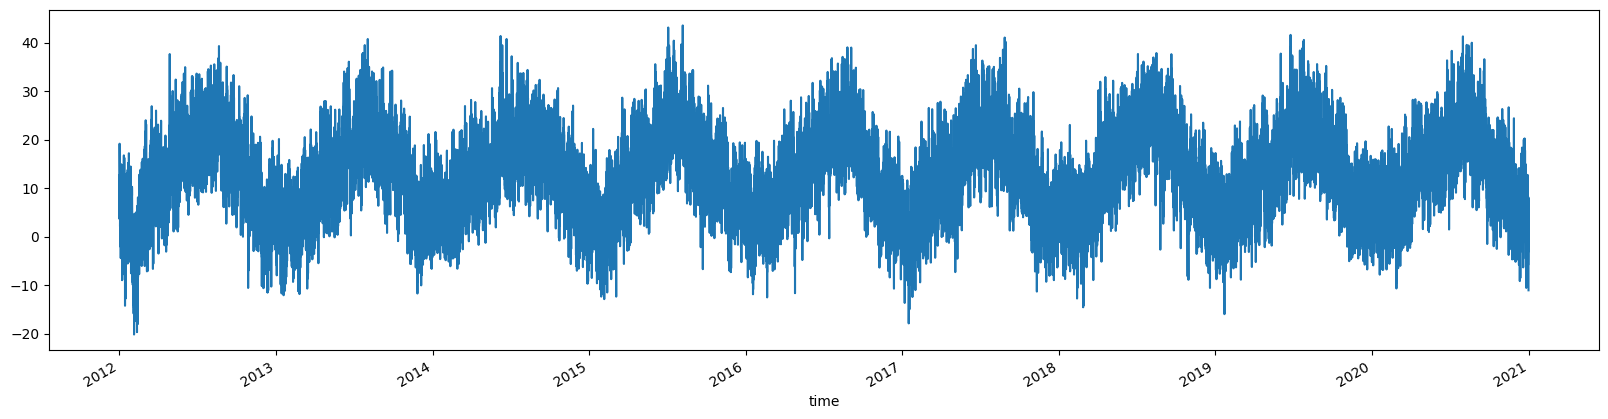

In [223]:
#Ploting how the pv power changes over the year 
time["T2m"].plot(figsize=(20,5))

<AxesSubplot:xlabel='y(t)', ylabel='y(t + 4250)'>

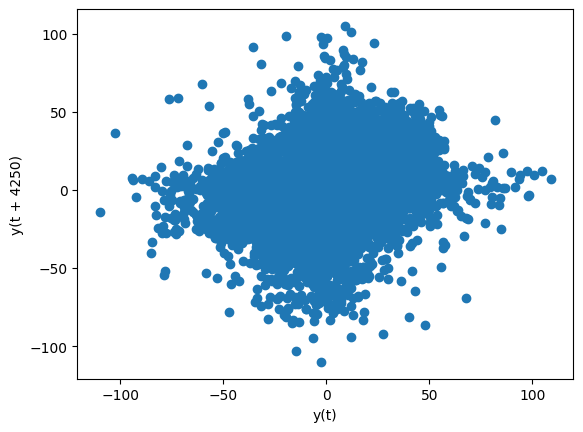

In [224]:
from pandas.plotting import lag_plot
# checking the lag plot to see if there's a positive or negative correlation.
lag_plot(time['target'].diff(), lag=4250)

It show that there is autocorrelation with some outliers 

<AxesSubplot:xlabel='hour_day', ylabel='target'>

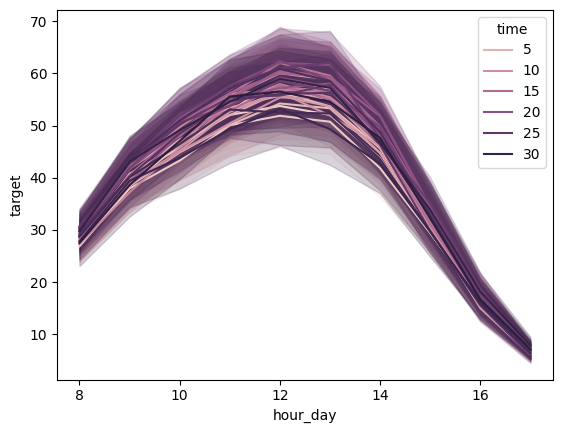

In [225]:
days = time.groupby(time.index.day)
sns.lineplot(data=time, x=time['hour_day'], y='target', hue=time.index.day)

<AxesSubplot:xlabel='hour_day', ylabel='target'>

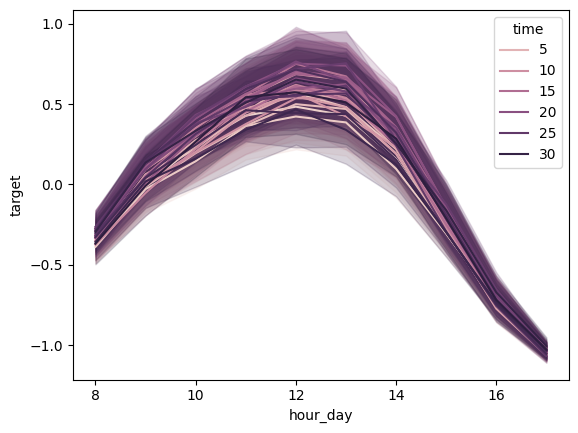

In [226]:
time_n = time.copy()
time_n['target'] =  ((time['target'] - time['target'].mean()) / time['target'].std())
sns.lineplot(data=time_n, x=time_n['hour_day'], y='target', hue=time_n.index.day)#, err_style=None)

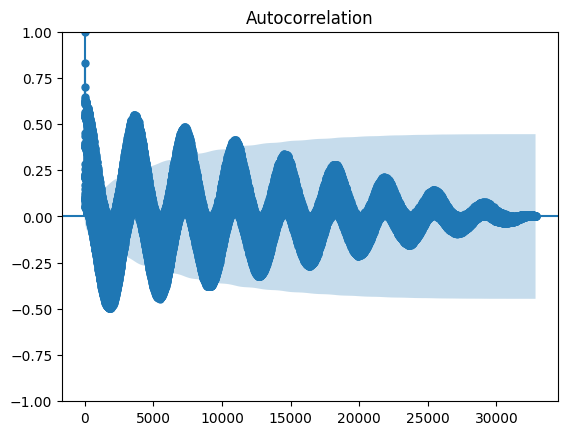

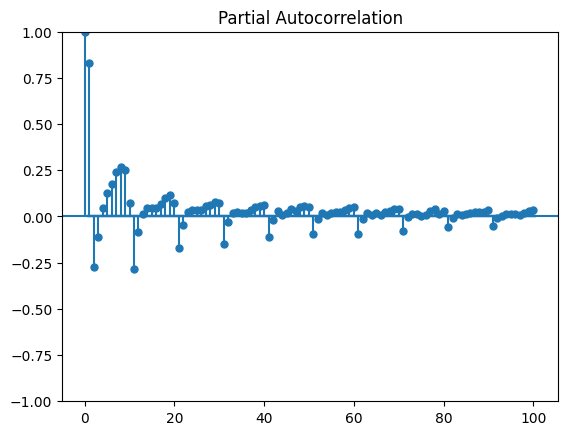

In [232]:
from pandas.plotting import autocorrelation_plot
import statsmodels.graphics.tsaplots as tsp

#autocorrelation_plot(time['target'])
#plt.show()
tsp.plot_acf(time['target'], lags=32850,fft=True)
tsp.plot_pacf(time['target'], lags=100)
plt.show()

In [228]:
pv_df = pd.DataFrame(env_dict['train_scenarios']['1y']['clients_data'][0][0], columns= env_dict['feature_names'])
pv_df['power'] = env_dict['train_scenarios']['1y']['clients_data'][0][1]
pv_df.head()

H_sun        T2m     WS10m  station_irrad_direct_prev      lag 1  \
0  42.94  15.524065  0.530438                  79.392482  39.430490   
1  52.56  18.805551  0.726292                 298.903755  55.250600   
2  60.60  26.382838 -0.433745                 507.413776  77.595283   
3  65.18  20.922109  1.011302                 600.501878  80.101307   
4  64.26  25.146308  1.888838                 740.892135  96.763388   

       lag 2      lag 3      lag 4     lag 18     lag 20  ...     lag 44  \
0  14.200172  11.384026   1.637198  55.473192  22.190663  ...  23.294380   
1  39.430490  14.200172  11.384026  49.970019  36.082503  ...   8.896892   
2  55.250600  39.430490  14.200172  39.651113  55.473192  ...  76.971137   
3  77.595283  55.250600  39.430490  17.525200  49.970019  ...  69.338991   
4  80.101307  77.595283  55.250600   3.914955  39.651113  ...  41.461877   

       lag 69      lag 70      lag 72     lag 74    lag 121    lag 145  \
0   96.808815   52.552184   40.493808   6.480240  35.155309  38.046782   
1  102.294143   96.808815   70.703709  31.748397  50.659145   9.606982   
2  100.054806  102.294143   52.552184  40.493808  53.607289  51.941692   
3   87.265646  100.054806   96.808815  70.703709  44.258075  73.962792   
4   69.474812   87.265646  102.294143  52.552184  26.867115  46.712363   

     lag 169     lag 190       power  
0  30.910529   90.883070   55.250600  
1  53.833140   98.378606   77.595283  
2  77.995862  110.185191   80.101307  
3  91.301400  110.035325   96.763388  
4  95.170304   90.499595  101.079814  

[5 rows x 23 columns]

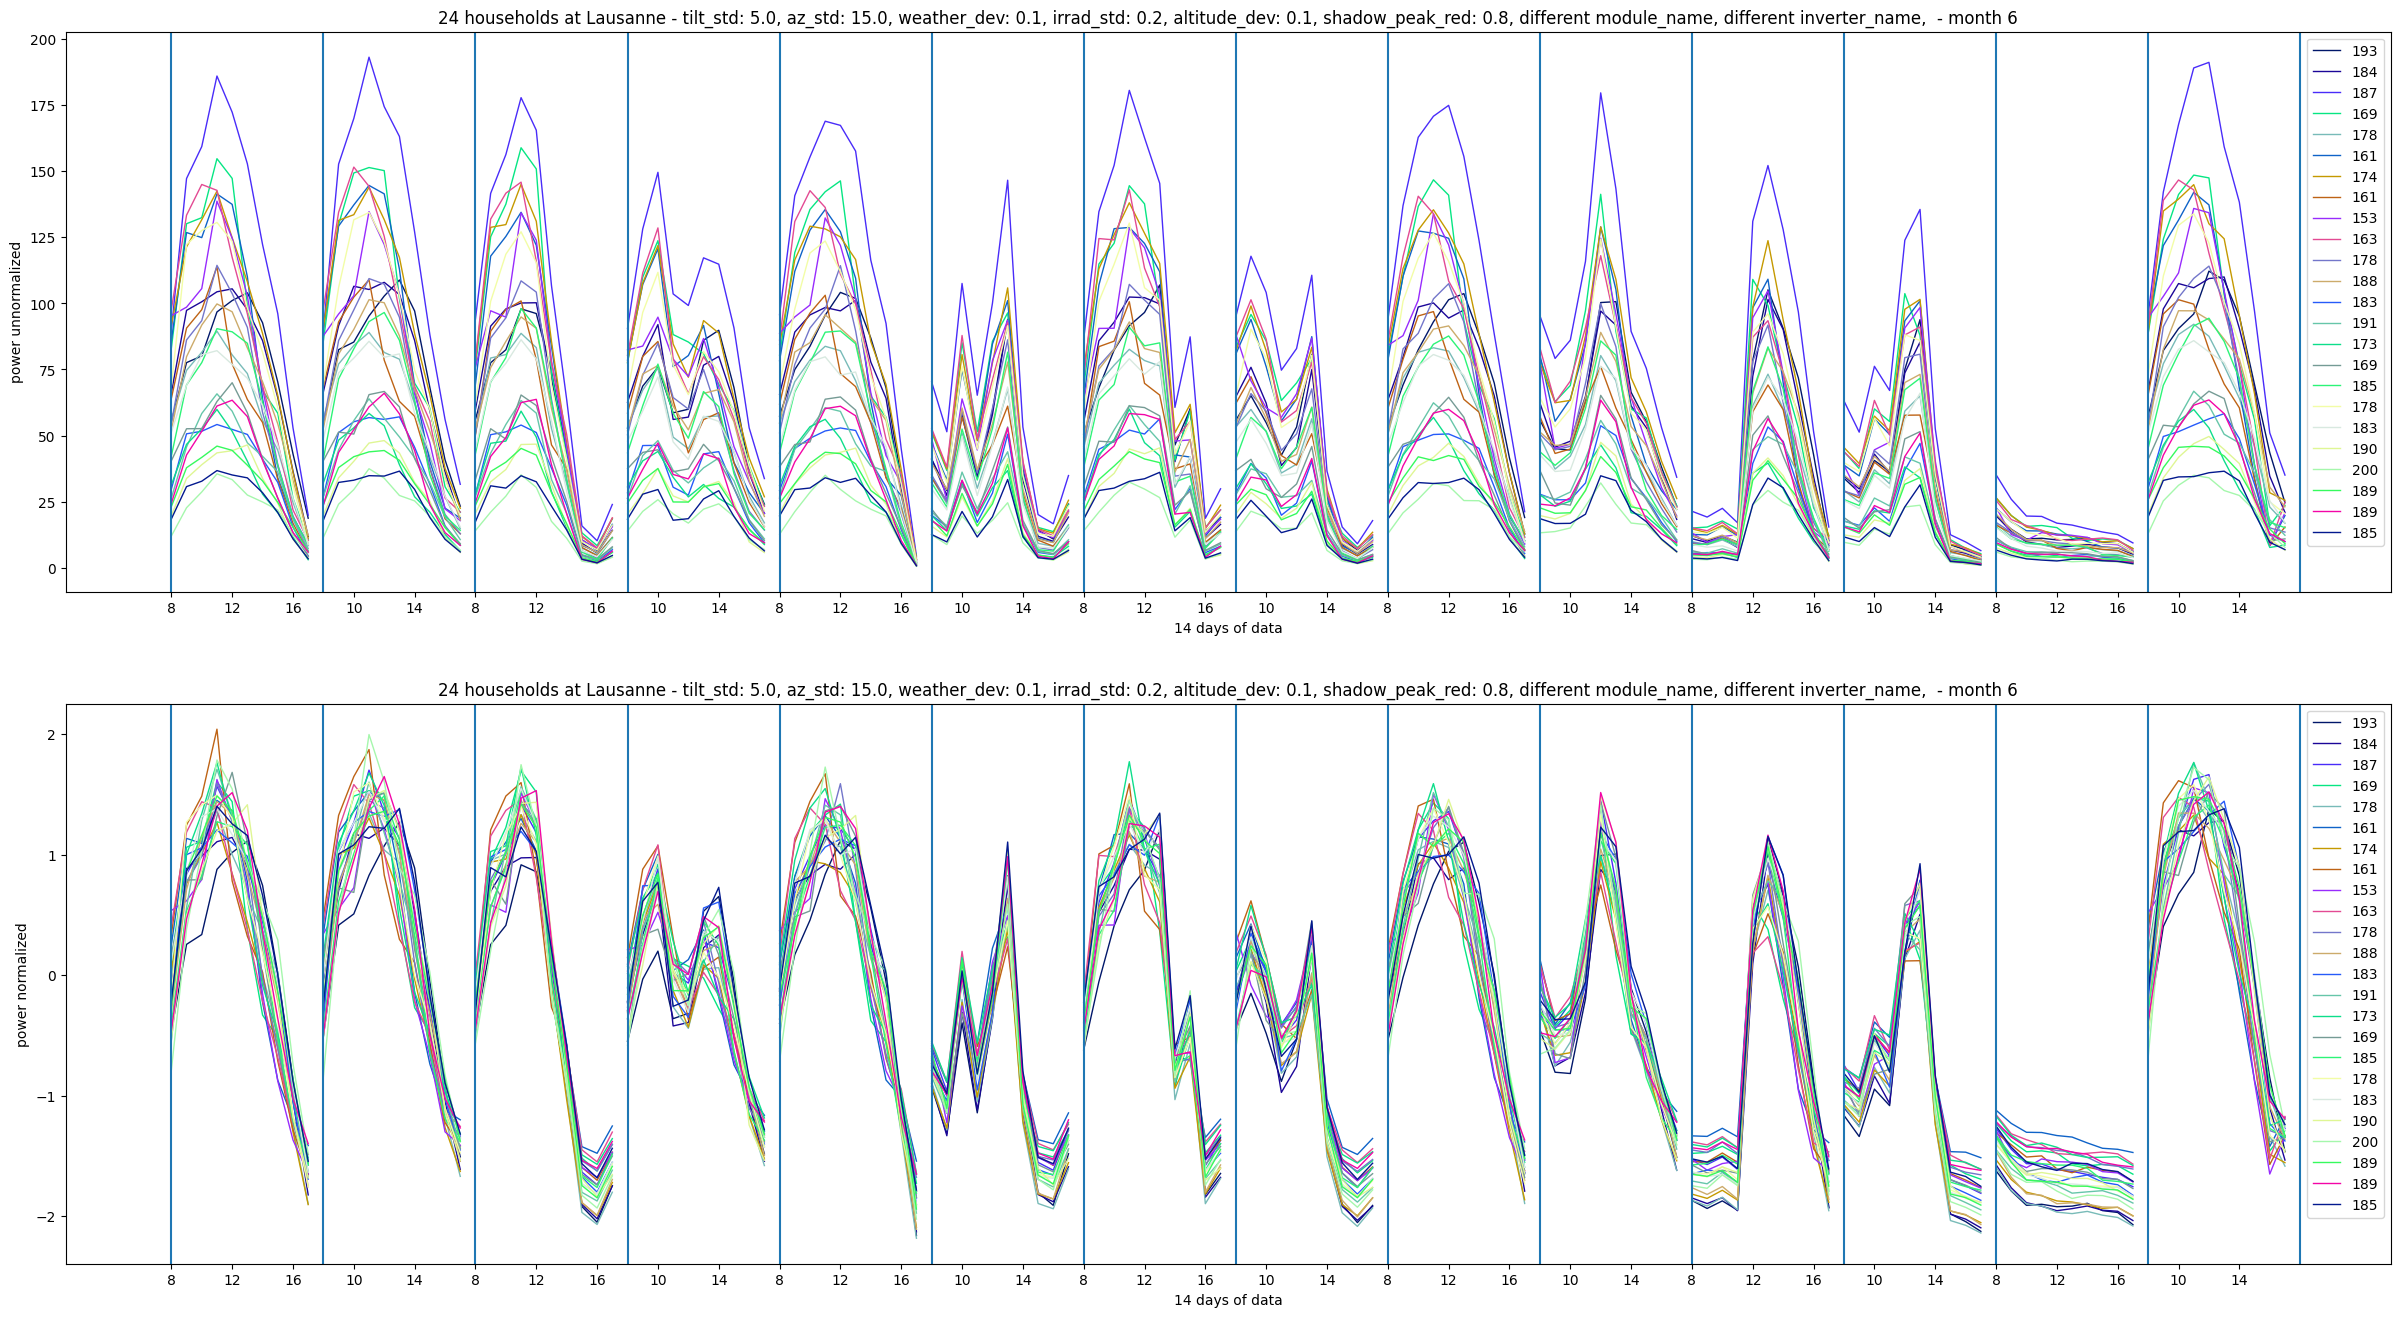

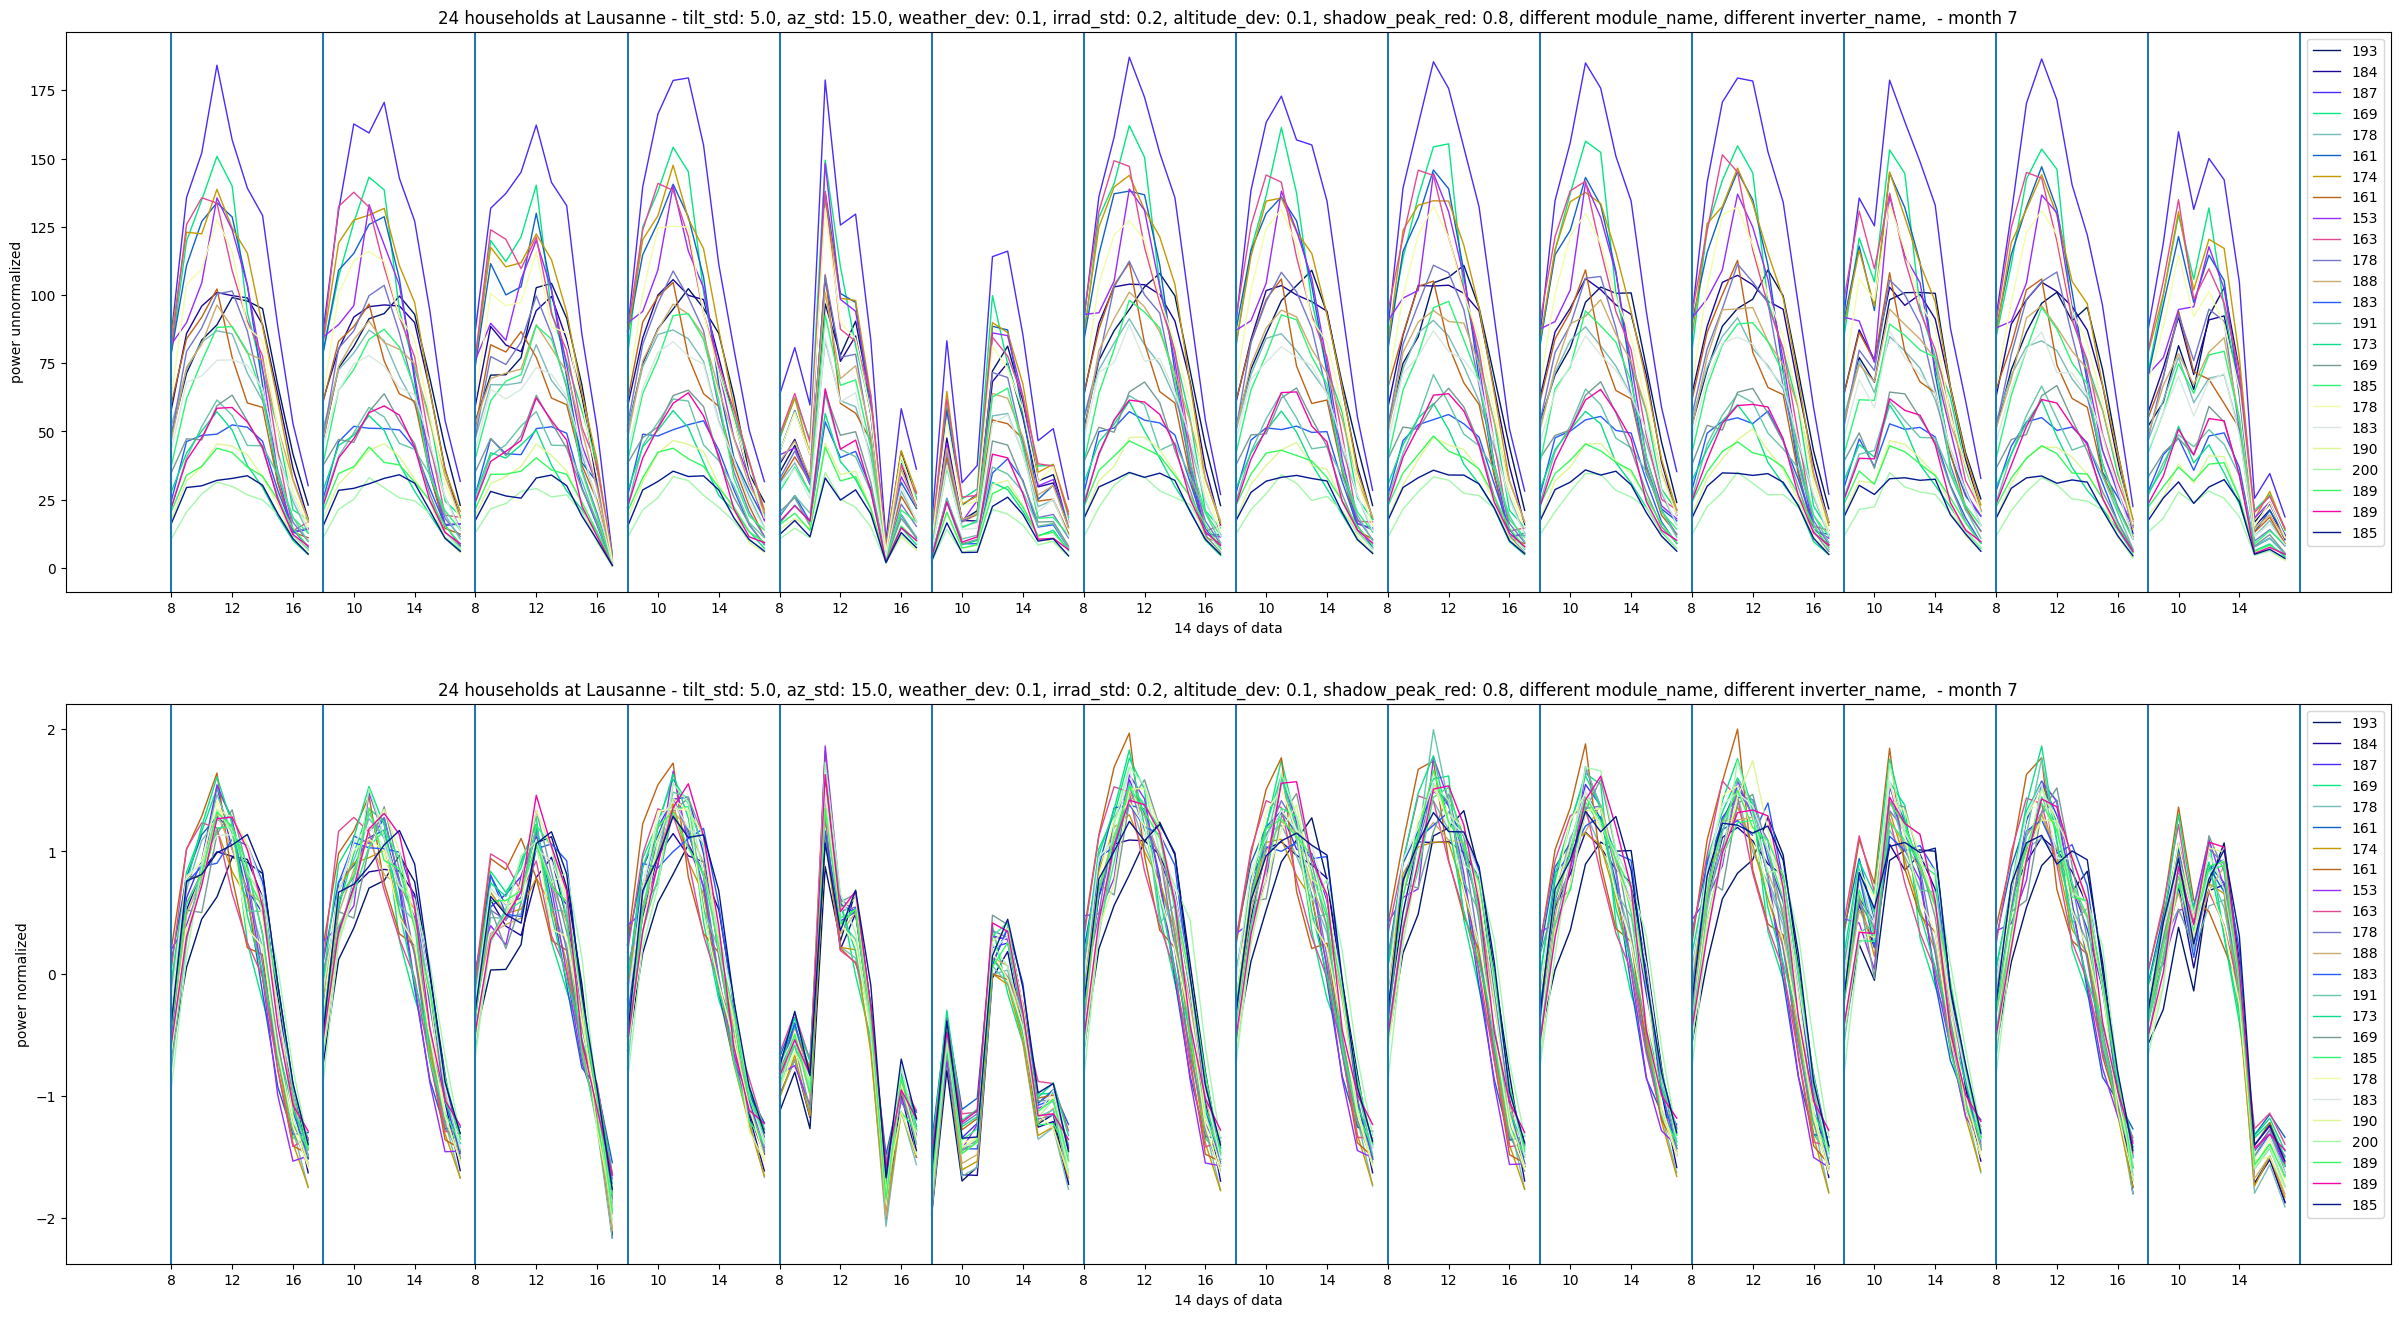

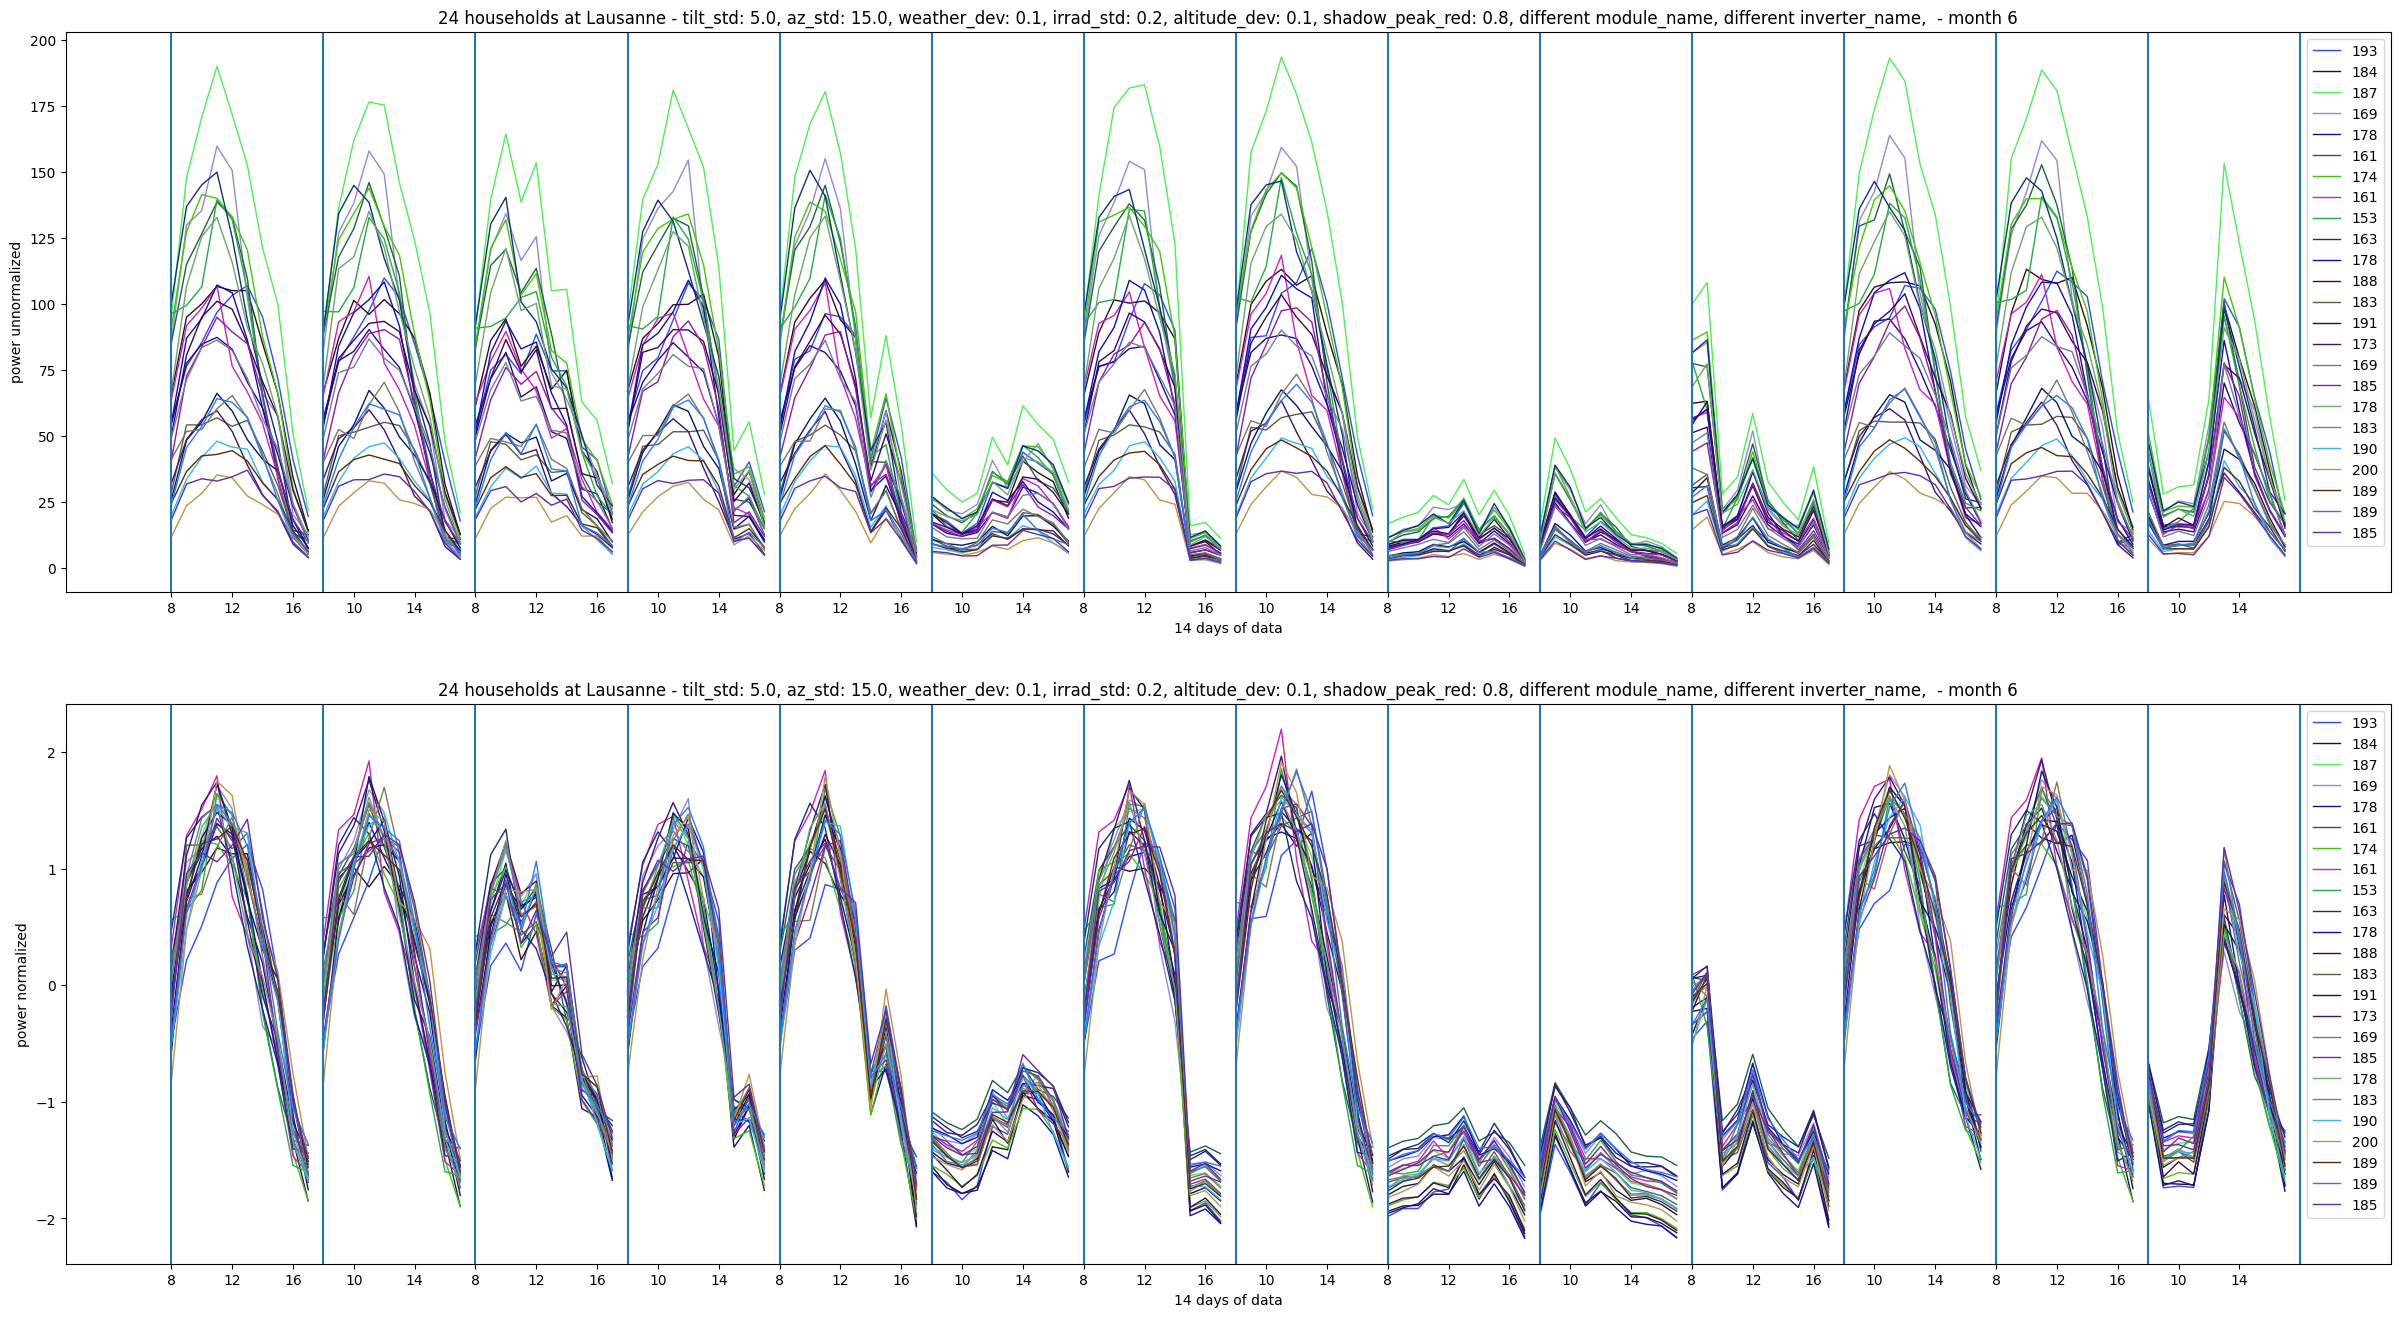

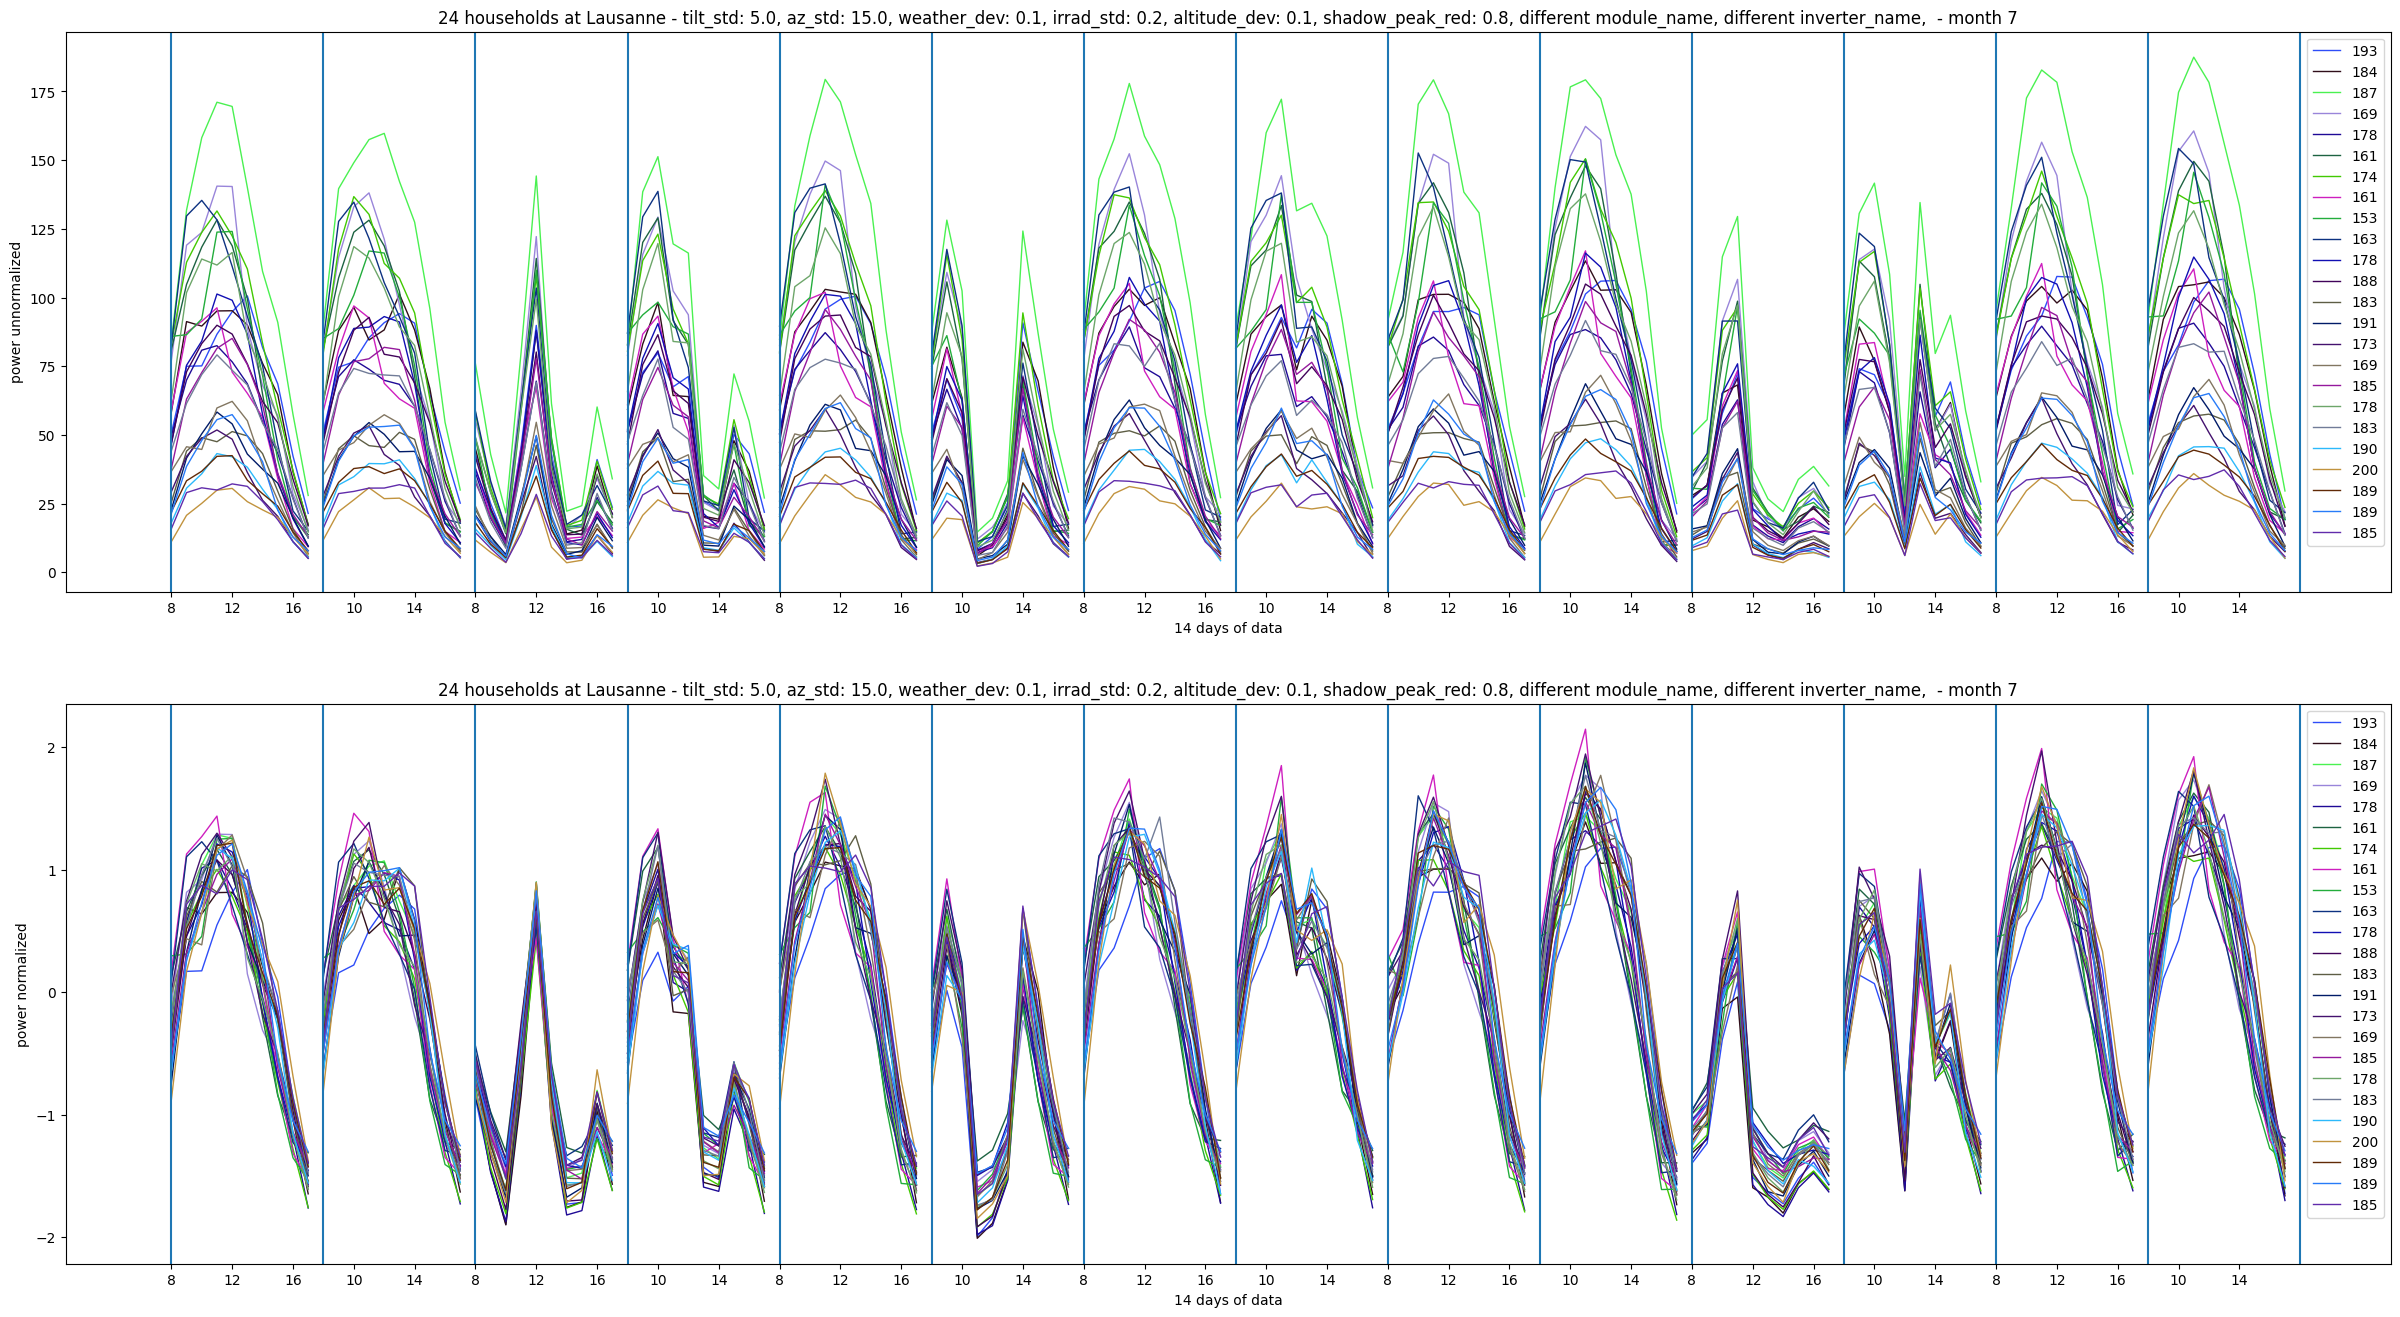

In [135]:
visualize_env(env_dict, num_days=14, year=2018, scenario_name=None)
visualize_env(env_dict, num_days=14, year=2019, scenario_name=None)

#Label the graphs to know the azimuth angle and the tilt angle

### Normalization
* For each client, we normalize both the features and the output.
* Normalization is done for both training and validation dataset using the mean and std of the "training data".
* Thus, all features and the output in the training data will have a zero mean and std of one. 
* In the validation set, the mean and std would not be exactly 0 and 1, but rather close to these values.

In [136]:
from utils_pv import normalize_data_tup

# normalizing the data with 150 training samples
scenario_name = 'sml'
clients_data = env_dict['train_scenarios'][scenario_name]['clients_data']
clients_data_nrm = [None]*len(clients_data)
for client_num in np.arange(env_dict['num_clients']):
    clients_data_nrm[client_num], _, _ = normalize_data_tup(clients_data[client_num])


In [137]:
len(clients_data_nrm[1])

4

### Ridge regression
With automatic penalty tuning

Evaluation metrics:
* root mean squared error (RMSE): positive value, a lower score is preferred
* adjusted r squared: between 0 and 1, closer to 1 is better


Notes on evaluation metrics: 
* calculate both measures on training and validation data. if training score is not good, the model is under-fitting, not trained well, or over-regularized. if the validation and training scores are far, the model is over-fitting.
* the metrics are calculated on the normalized data. This makes interpreting the results easier: if the model always predicts 0, RMSE train is 1 and RMSE valid is close to 1.

In [138]:
clients_data_nrm[0][0].shape

(150, 22)

In [139]:
from model_training.search_models import RidgeWrapper

# get normalized training and validation data
client_num = 0  # fit for the house number 0
x_train_nrm, y_train_nrm, x_valid_nrm, y_valid_nrm = clients_data_nrm[client_num]

# fit Ridge regression with grid search over penalty
ridge_wrapper = RidgeWrapper(alphas=np.logspace(-6,2,80)) # penalty weights to test
ridge_wrapper.fit(x_train_nrm, y_train_nrm)

# evaluate on training data
y_train_pred = ridge_wrapper.predict(x_train_nrm).reshape(y_train_nrm.shape)
rmse_train = np.mean((y_train_pred-y_train_nrm)**2)**0.5
adj_r2_train = adj_r2_scorer(ridge_wrapper, x_train_nrm, y_train_nrm)

# evaluate on validation data
y_valid_pred = ridge_wrapper.predict(x_valid_nrm).reshape(y_valid_nrm.shape)
rmse_valid = np.mean((y_valid_pred-y_valid_nrm)**2)**0.5
adj_r2_valid = adj_r2_scorer(ridge_wrapper, x_valid_nrm, y_valid_nrm)

msg = 'Ridge regression for client {:2.0f}:'.format(client_num)
msg += '\nbest results obtained by penalty factor = ' + str(ridge_wrapper.alpha)
msg += '\nRMSE train = {:1.4f}, RMSE valid = {:1.4f}'.format(rmse_train, rmse_valid)
msg += '\nAdj R2 train = {:1.4f}, Adj R2 valid = {:1.4f}'.format(adj_r2_train, adj_r2_valid)
print(msg)


Ridge regression for client  0:
best results obtained by penalty factor = 1.0
RMSE train = 0.3430, RMSE valid = 0.5234
Adj R2 train = 0.8620, Adj R2 valid = 0.7057


### More Complex Models
* try using bigger datasets, e.g. '1y' or '5y'
* normalize the data before fitting the model
* tune hyper-parameters, e.g., penalty, NN depth, etc., with cross validation

For convinience I will sort the data to have a single table to work with:

<AxesSubplot:xlabel='hour_day', ylabel='target'>

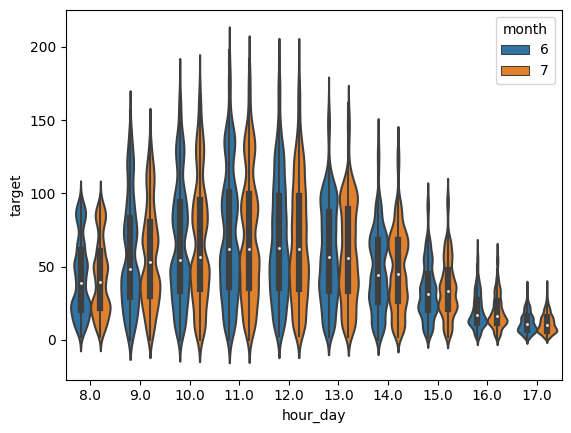

In [310]:
sns.violinplot(data=train_set, x=time['hour_day'], y='target', hue=train_set["month"])

## Kernel Ridge 
Here I will use a kernel to handle the non linearities of the ridge kernel. 

In [291]:
from sklearn.kernel_ridge import KernelRidge
import numpy as np
from sklearn.model_selection import GridSearchCV


alphas=np.logspace(-6,1,80)
ridge_clf = KernelRidge(
    alpha=1,
    kernel='polynomial',
    gamma=None,
    degree=5,
    coef0=1,
    kernel_params=None
)
grid_ridge_poly = GridSearchCV(estimator= ridge_clf, param_grid={'alpha': 1/alphas}, cv=6, return_train_score=True)

grid_ridge_poly.fit(x_train_nrm, y_train_nrm)

Trainig score: 0.9491132381278331
Test score: 0.7438705396605372
Best parameters: {'alpha': 8.899530352885224}


Trainig score: 0.9491132381278331
Test score: 0.7438705396605372
Best parameters: {'alpha': 8.899530352885224}


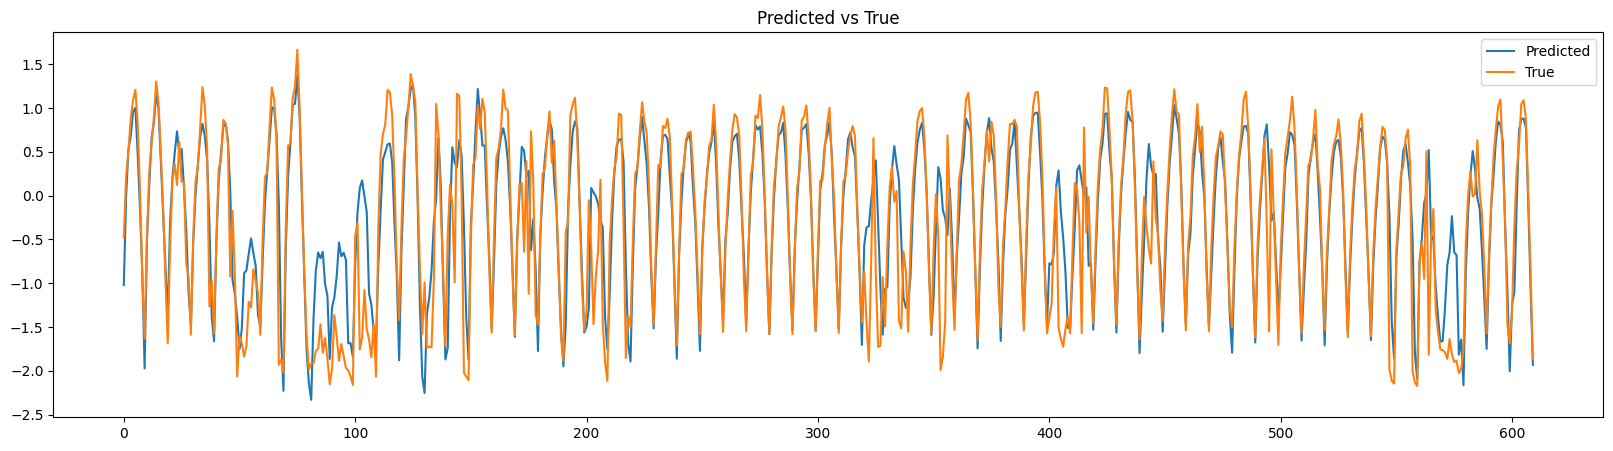

In [309]:
### Show the results of the grid search
def show_results(model_grid, X_train, y_train, X_valid, y_valid):
    print(f"Trainig score: {model_grid.score(X_train, y_train)}")
    print(f"Test score: {model_grid.score(X_valid, y_valid)}")
    print(f"Best parameters: {model_grid.best_params_}")

    Target_test = model_grid.predict(X_valid)
    Target_true = y_valid
    plt.figure(figsize=(20,5))
    plt.plot(Target_test, label='Predicted')
    plt.plot(Target_true, label='True')
    plt.legend()
    plt.title('Predicted vs True')
    plt.show()
    plt.close()

show_results(grid_ridge_poly, x_train_nrm, y_train_nrm, x_valid_nrm, y_valid_nrm)

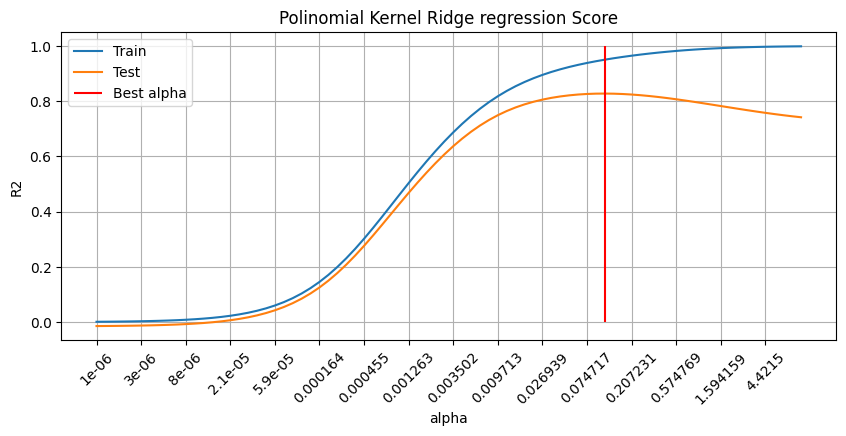

In [306]:
train_loss = grid_ridge_poly.cv_results_['mean_train_score']
test_loss = grid_ridge_poly.cv_results_['mean_test_score']
plt.figure(figsize=(10,4))
plt.plot(train_loss, label='Train')
plt.plot(test_loss, label='Test')
plt.xticks(np.arange(0,80,5), [n.round(6) for n in alphas[np.arange(0,80,5)]], rotation=45)
plt.vlines(grid_ridge_poly.best_index_, 0, 1, color='red', label='Best alpha')
plt.xlabel('alpha')
plt.ylabel('R2')
plt.title('Polinomial Kernel Ridge regression Score')
plt.grid()
plt.legend()
plt.show()
plt.close()
